In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential# data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skincancer-dataset/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024371.jpg
/kaggle/input/skincancer-dataset/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024358.jpg
/kaggle/input/skincancer-dataset/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024337.jpg
/kaggle/input/skincancer-dataset/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024382.jpg
/kaggle/input/skincancer-dataset/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024420.jpg
/kaggle/input/skincancer-dataset/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024409.jpg
/kaggle/input/skincancer-dataset/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024336.jpg
/kaggle/input/skincancer-dataset/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024422.jpg
/kaggle/input/skincancer-dataset/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024408.jpg
/kaggle/input/skincancer-dataset/CNN_assignment/Dataset

In [3]:
path_to_train_directory='/kaggle/input/skincancer-dataset/CNN_assignment/Dataset/Train'
path_to_test_directory='/kaggle/input/skincancer-dataset/CNN_assignment/Dataset/Test'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training"
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

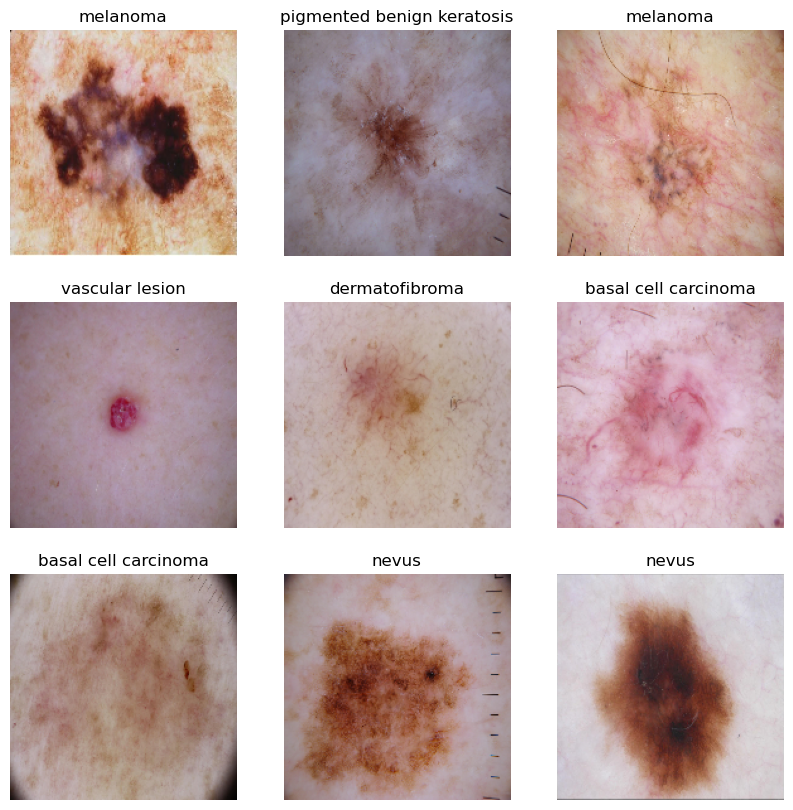

In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(9,activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [13]:
model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
56/56 [==============================] - 31s 96ms/step - loss: 1.9888 - accuracy: 0.2522 - val_loss: 1.8598 - val_accuracy: 0.3177
Epoch 2/3
56/56 [==============================] - 1s 20ms/step - loss: 1.7556 - accuracy: 0.3538 - val_loss: 1.6576 - val_accuracy: 0.3803
Epoch 3/3
56/56 [==============================] - 1s 20ms/step - loss: 1.5163 - accuracy: 0.4554 - val_loss: 1.4309 - val_accuracy: 0.5011


In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3536 - accuracy: 0.5179 - val_loss: 1.4578 - val_accuracy: 0.5123
Epoch 2/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2630 - accuracy: 0.5625 - val_loss: 1.3353 - val_accuracy: 0.5213
Epoch 3/20
56/56 [==============================] - 1s 19ms/step - loss: 1.1773 - accuracy: 0.5882 - val_loss: 1.4052 - val_accuracy: 0.5347
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.0806 - accuracy: 0.6150 - val_loss: 1.3601 - val_accuracy: 0.5436
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 0.9517 - accuracy: 0.6479 - val_loss: 1.4828 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 0.8538 - accuracy: 0.6970 - val_loss: 1.7039 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 0.7606 - accuracy: 0.7266 - val_loss: 1.7137 - val_accuracy: 0.5347
Epoch 8/20
56

### Visualizing training results

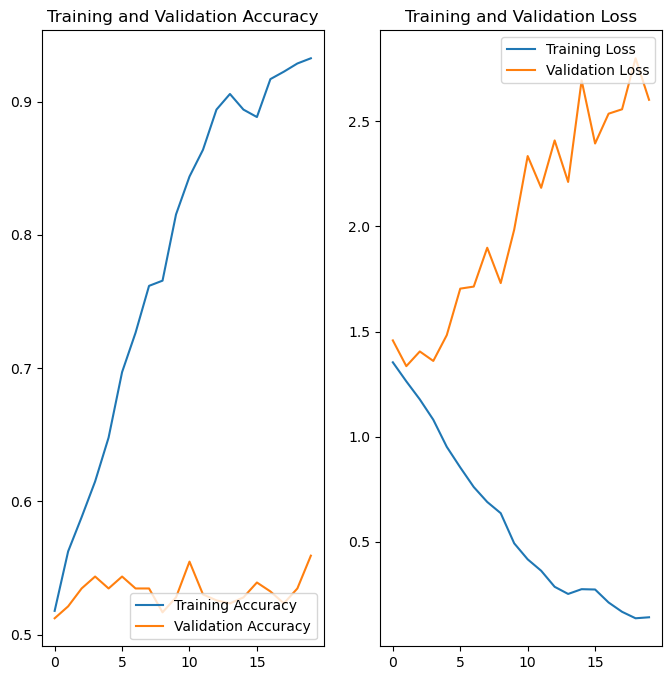

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

## 1)As per the graph and results we can easily determine that it is a situation  of Overfitting. 
## 2)The last epoch shows huge difference between the validation accuracy and the training accuracy. Thus we have to overcome it.

Text(0.5, 1.0, 'melanoma')

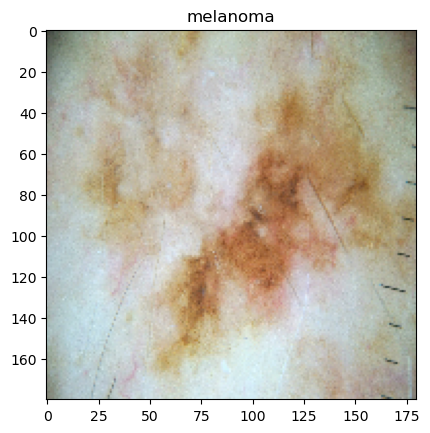

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# To reduce overfitting we can se augmentation strategies like flipping, rotation, blurring, rotation etc.
#let's use image brightness as the strategy for once

image, label = next(iter(train_ds))
plt.imshow(image[0].numpy()/255)
plt.title(class_names[label[0].numpy()])

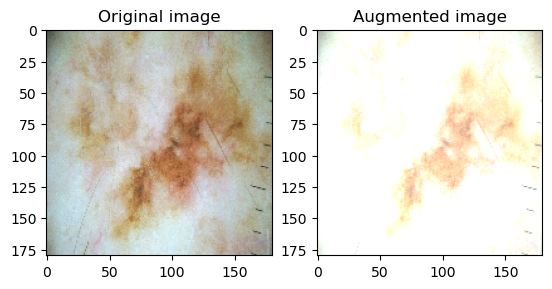

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here  
### Here I have tried using brightness
def augment(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

bright = tf.image.adjust_brightness(image[0].numpy()/255, 0.4)
augment(image[0].numpy()/255, bright)

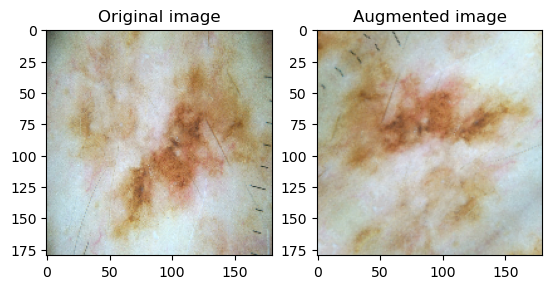

In [19]:
### Here I have tried using rotation and creating as a layer (This layer we will use ahead)

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
])


augmented_image = data_augmentation(image[0].numpy()/255)

augment(image[0].numpy()/255,augmented_image)

### Todo:
### Create the model, compile and train the model

In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = tf.keras.Sequential([  
  layers.experimental.preprocessing.Rescaling(1./255),
  data_augmentation,
  layers.Conv2D(16, 3, activation='relu'),  
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, 3, activation='relu'),   
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(9,activation='softmax')
])

### Compiling the model

In [21]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=20
)## your training code


Epoch 1/20
56/56 [==============================] - 9s 96ms/step - loss: 2.0687 - accuracy: 0.2405 - val_loss: 1.9065 - val_accuracy: 0.3154
Epoch 2/20
56/56 [==============================] - 5s 92ms/step - loss: 1.8367 - accuracy: 0.3164 - val_loss: 1.6846 - val_accuracy: 0.4139
Epoch 3/20
56/56 [==============================] - 5s 93ms/step - loss: 1.7125 - accuracy: 0.3761 - val_loss: 1.5471 - val_accuracy: 0.4966
Epoch 4/20
56/56 [==============================] - 5s 91ms/step - loss: 1.5874 - accuracy: 0.4358 - val_loss: 1.5161 - val_accuracy: 0.4564
Epoch 5/20
56/56 [==============================] - 5s 93ms/step - loss: 1.5348 - accuracy: 0.4710 - val_loss: 1.4074 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 5s 92ms/step - loss: 1.4623 - accuracy: 0.4838 - val_loss: 1.4050 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 5s 92ms/step - loss: 1.4838 - accuracy: 0.4799 - val_loss: 1.4019 - val_accuracy: 0.5101
Epoch 8/20
56

### Visualizing the results

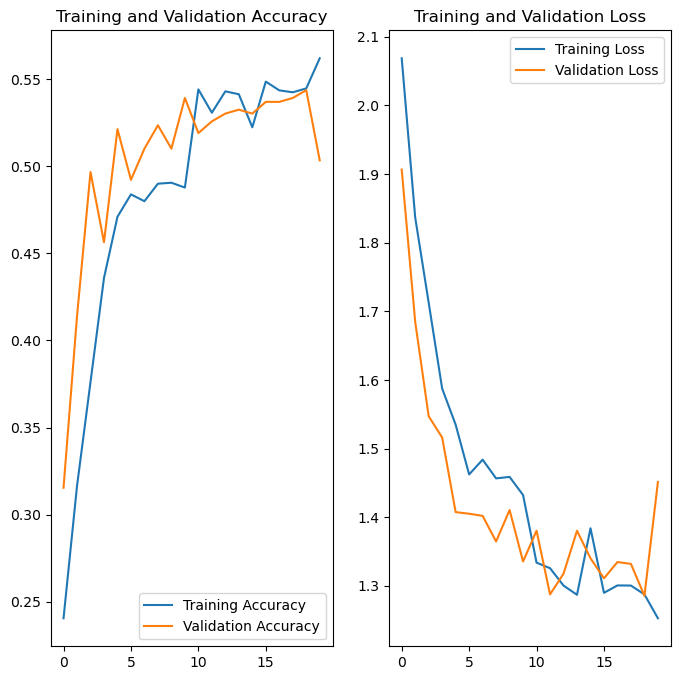

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?




### **Overfitting has been reduced now  which is a big difference and the validation accuracy has been improved now** . The validation accuracy is a little better but not that great . Still we need to apply few more changes for better results.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

[ 92 309  77 352 277 370  58 142 115]


Text(0.5, 1.0, 'Class distribution in training set')

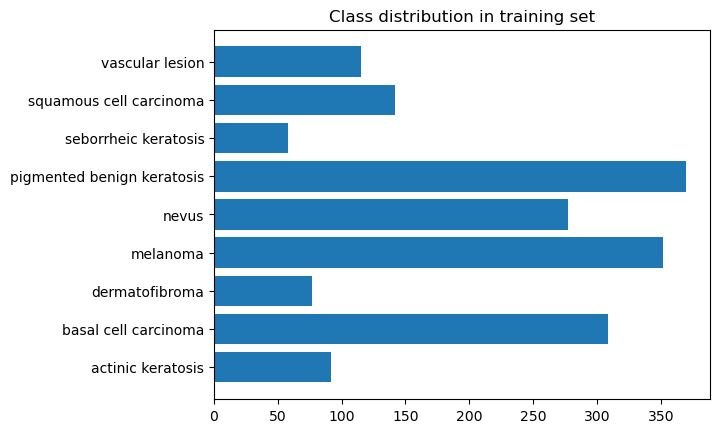

In [24]:
## Your code goes here.

count = np.zeros(9, dtype=np.int32)
for _, labels in train_ds:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()
print(count)

plt.barh(class_names, count)
plt.title('Class distribution in training set')

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
## According to the data, **seborrheic keratosis** has the least number of samples.
#### - Which classes dominate the data in terms proportionate number of samples?
## **pigmented benign keratosis** dominates the count in the number of samples.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [33]:
from distutils.dir_util import copy_tree
source_dir='/kaggle/input/skincancer-dataset'
destination_dir = '/kaggle/working'
copy_tree(source_dir,destination_dir)

['/kaggle/working/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024371.jpg',
 '/kaggle/working/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024358.jpg',
 '/kaggle/working/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024337.jpg',
 '/kaggle/working/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024382.jpg',
 '/kaggle/working/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024420.jpg',
 '/kaggle/working/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024409.jpg',
 '/kaggle/working/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024336.jpg',
 '/kaggle/working/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024422.jpg',
 '/kaggle/working/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024408.jpg',
 '/kaggle/working/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_0024381.jpg',
 '/kaggle/working/CNN_assignment/Dataset/Test/pigmented benign keratosis/ISIC_00

In [34]:
path_to_training_dataset='/kaggle/working/CNN_assignment/Dataset/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/CNN_assignment/Dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7605044FEFD0>: 100%|██████████| 500/500 [00:16<00:00, 30.02 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/CNN_assignment/Dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7605F80B4150>: 100%|██████████| 500/500 [00:17<00:00, 28.73 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/CNN_assignment/Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x760508714A10>: 100%|██████████| 500/500 [00:17<00:00, 29.17 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/CNN_assignment/Dataset/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x76057052EA90>: 100%|██████████| 500/500 [01:27<00:00,  5.70 Samples/s]  


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/CNN_assignment/Dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7605044F58D0>: 100%|██████████| 500/500 [01:27<00:00,  5.71 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/CNN_assignment/Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x760570518950>: 100%|██████████| 500/500 [00:16<00:00, 29.96 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/CNN_assignment/Dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x760570518910>: 100%|██████████| 500/500 [00:40<00:00, 12.45 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/CNN_assignment/Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x76057C255E10>: 100%|██████████| 500/500 [00:16<00:00, 30.12 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/CNN_assignment/Dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7606110B5190>: 100%|██████████| 500/500 [00:17<00:00, 28.63 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
data_dir_train_new=pathlib.Path('/kaggle/working/CNN_assignment/Dataset/Train')
image_count_train = len(list(data_dir_train_new.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train_new, '*','output', '*.jpg'))]
path_list

['/kaggle/working/CNN_assignment/Dataset/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025331.jpg_b62916c1-4425-4fee-b90a-a09b38cc7efc.jpg',
 '/kaggle/working/CNN_assignment/Dataset/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027506.jpg_1237c4a0-39bd-4b34-a50f-6813bedc5596.jpg',
 '/kaggle/working/CNN_assignment/Dataset/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026522.jpg_6f756738-5972-4681-a8fb-4ed41bc473ac.jpg',
 '/kaggle/working/CNN_assignment/Dataset/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024843.jpg_aa062976-5cb0-4efa-822f-a6ced4d3cd14.jpg',
 '/kaggle/working/CNN_assignment/Dataset/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029598.jpg_1c580f7a-26af-4666-b10b-127c3f96b742.jpg',
 '/kaggle/working/CNN_assignment/Dataset/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031119.jpg_e7e98173-6ac0-437

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train_new, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [40]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
df2

,Path,Label
0,/kaggle/working/CNN_assignment/Dataset/Train/s...,squamous cell carcinoma
1,/kaggle/working/CNN_assignment/Dataset/Train/s...,squamous cell carcinoma
2,/kaggle/working/CNN_assignment/Dataset/Train/s...,squamous cell carcinoma
3,/kaggle/working/CNN_assignment/Dataset/Train/s...,squamous cell carcinoma
4,/kaggle/working/CNN_assignment/Dataset/Train/s...,squamous cell carcinoma
...,...,...
4495,/kaggle/working/CNN_assignment/Dataset/Train/b...,basal cell carcinoma
4496,/kaggle/working/CNN_assignment/Dataset/Train/b...,basal cell carcinoma
4497,/kaggle/working/CNN_assignment/Dataset/Train/b...,basal cell carcinoma
4498,/kaggle/working/CNN_assignment/Dataset/Train/b...,basal cell carcinoma


In [42]:
df2['Label'].value_counts()

squamous cell carcinoma       500
pigmented benign keratosis    500
seborrheic keratosis          500
dermatofibroma                500
actinic keratosis             500
vascular lesion               500
melanoma                      500
nevus                         500
basal cell carcinoma          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [44]:
data_dir_train=pathlib.Path('/kaggle/working/CNN_assignment/Dataset/Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [51]:
## your code goes here
from tensorflow.keras.regularizers import l2
model = tf.keras.Sequential([  
  layers.experimental.preprocessing.Rescaling(1./255),
  data_augmentation,
  layers.Conv2D(16, 3, activation='relu'),  
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, 3, activation='relu'), 
  layers.BatchNormalization(),   
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(9,activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [52]:
## your code goes here
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

#### **Todo:**  Train your model

In [53]:
epochs = 30
## Your code goes here, use 50 epochs.
history =model.fit(train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)
 # your model fit code

Epoch 1/30
169/169 [==============================] - 39s 196ms/step - loss: 2.0351 - accuracy: 0.3540 - val_loss: 3.3063 - val_accuracy: 0.1084
Epoch 2/30
169/169 [==============================] - 33s 193ms/step - loss: 1.6009 - accuracy: 0.4432 - val_loss: 2.7346 - val_accuracy: 0.2042
Epoch 3/30
169/169 [==============================] - 33s 191ms/step - loss: 1.4442 - accuracy: 0.4774 - val_loss: 1.7330 - val_accuracy: 0.3630
Epoch 4/30
169/169 [==============================] - 33s 193ms/step - loss: 1.2107 - accuracy: 0.5480 - val_loss: 2.4910 - val_accuracy: 0.3460
Epoch 6/30
169/169 [==============================] - 33s 192ms/step - loss: 1.1783 - accuracy: 0.5523 - val_loss: 1.8207 - val_accuracy: 0.3660
Epoch 7/30
169/169 [==============================] - 34s 196ms/step - loss: 1.1088 - accuracy: 0.5814 - val_loss: 2.1173 - val_accuracy: 0.2984
Epoch 8/30
169/169 [==============================] - 33s 193ms/step - loss: 1.0437 - accuracy: 0.6042 - val_loss: 1.4830 - val_ac

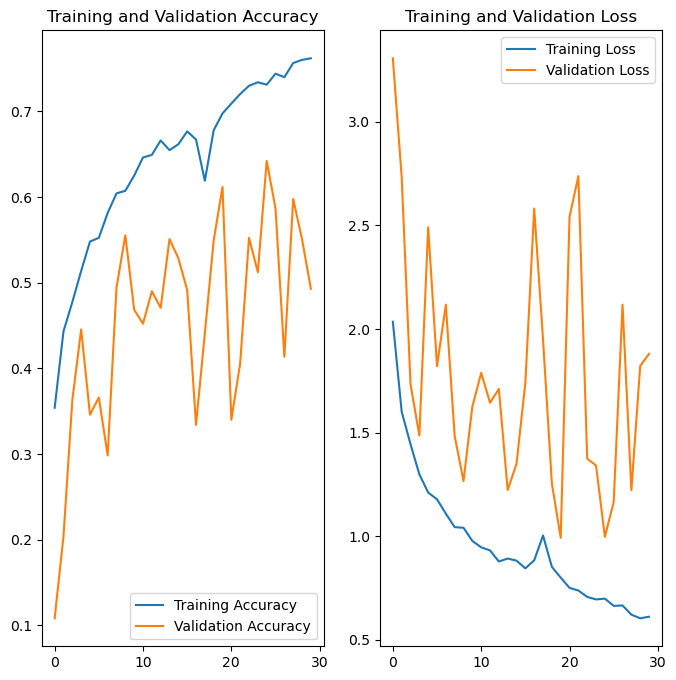

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### It seems class rebalancing hhas not impacted completely. The validation accuracy for 30 epochs and the training accuracy still undergo overfitting.
### Batch Normalization though helps in reducing overfitting it seems it isn't working under this . May be the network I have built is not quite good and doe not give intended results so need to tweak a little bit.
Trying once more

In [55]:
## your code goes here
from tensorflow.keras.regularizers import l2
model = tf.keras.Sequential([  
  layers.experimental.preprocessing.Rescaling(1./255),
  data_augmentation,
  layers.Conv2D(16, 3, activation='relu'),  
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, 3, activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, 3, activation='relu'), 
  layers.BatchNormalization(),   
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(9,activation='softmax')
])

In [56]:
## your code goes here
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [57]:
epochs = 30
## Your code goes here, use 50 epochs.
history =model.fit(train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)
 # your model fit code

Epoch 1/30
169/169 [==============================] - 40s 204ms/step - loss: 2.0770 - accuracy: 0.3774 - val_loss: 2.9718 - val_accuracy: 0.1195
Epoch 2/30
169/169 [==============================] - 35s 205ms/step - loss: 1.6015 - accuracy: 0.4468 - val_loss: 2.2830 - val_accuracy: 0.1618
Epoch 3/30
169/169 [==============================] - 34s 199ms/step - loss: 1.4600 - accuracy: 0.4766 - val_loss: 1.7524 - val_accuracy: 0.4001
Epoch 4/30
169/169 [==============================] - 33s 191ms/step - loss: 1.3456 - accuracy: 0.5011 - val_loss: 1.3000 - val_accuracy: 0.5219
Epoch 5/30
169/169 [==============================] - 33s 190ms/step - loss: 1.2572 - accuracy: 0.5380 - val_loss: 1.7159 - val_accuracy: 0.4165
Epoch 6/30
169/169 [==============================] - 33s 192ms/step - loss: 1.1799 - accuracy: 0.5593 - val_loss: 1.3644 - val_accuracy: 0.4922
Epoch 7/30
169/169 [==============================] - 33s 190ms/step - loss: 1.1115 - accuracy: 0.5912 - val_loss: 1.2771 - val_ac

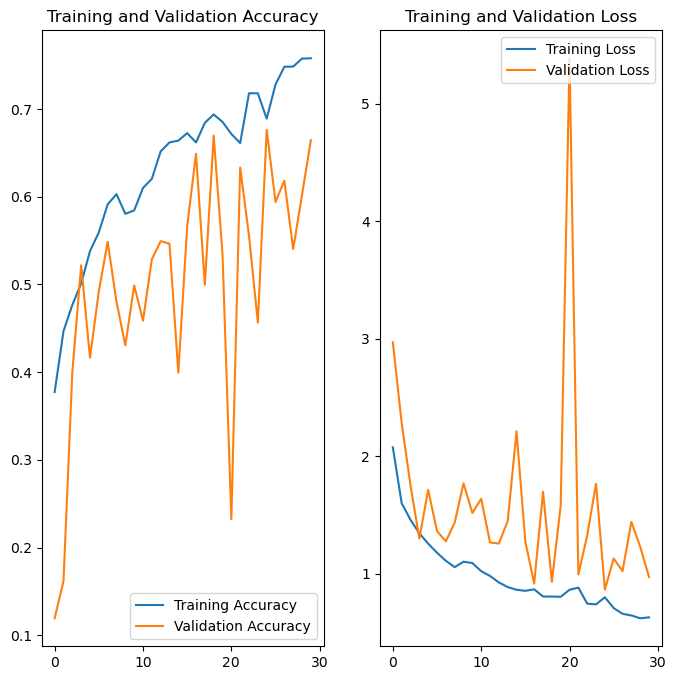

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## In this overfitting is quite less compared to previous versions. We can see the number of neurons matter in the dense layer. Increasing that improved the model by 10 %.